There are many of them what we are going to consider here is decision tree.

# Decision Tree

In [50]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import math
import pydot
from IPython.display import Image, display
from collections import namedtuple

In [66]:
class Node:
    def __init__(self):
        self.left = None
        self.right = None
        
    def is_leaf(self):
        return self.left is None and self.right is None
    
    def __str__(self):
        return 'hello'
test_root = Node()
test_root.left = Node()
test_root.right = Node()
print id(test_root), str(test_root)


4400257648 hello


In [132]:
def visualize_tree(node, depth_limit=10):
    graph = pydot.Dot(graph_type='digraph')
    visualize_tree_helper(node, graph, 0, depth_limit=depth_limit)
    display(Image(graph.create_png()))
    return graph
    
def visualize_tree_helper(node, graph, depth, depth_limit=10):
    
    if depth > depth_limit:
        print 'Traversing too deep'
        dotnode = pydot.Node('n%d'%id(node), label=str(node), shape="diamond", fillcolor="green", style="filled")
        graph.add_node(dotnode)
        return dotnode
    
    
    if not node.is_leaf():
        dotnode = pydot.Node('n%d'%id(node),label=str(node), shape="box")
    else:
        dotnode = pydot.Node('n%d'%id(node),label=str(node), shape="ellipse")
    graph.add_node(dotnode)
    
    if node.left is not None:
        dotleft = visualize_tree_helper(node.left, graph, depth+1, depth_limit)
        edge = pydot.Edge(dotnode, dotleft)
        graph.add_edge(edge)
    if node.right is not None:
        dotright = visualize_tree_helper(node.right, graph, depth+1, depth_limit)
        edge = pydot.Edge(dotnode, dotright)
        graph.add_edge(edge)
    return dotnode

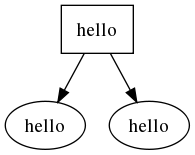

In [133]:
graph = visualize_tree(test_root)

In [134]:
# how a decision tree works
# how to grow a tree
class DecisionNode(Node):
    def __init__(self):
        Node.__init__(self)
        self.npos = 0
        self.nneg = 0
        self.vid = None
        self.cut = None
        
    def classify(self, data):
        if self.is_leaf():
            return float(self.npos)/(self.npos + self.nneg)
        
        if data[self.vid] > self.cut:
            return self.right.classify(data)
        else:
            return self.left.classify(data)
    
    def __str__(self):
        if self.is_leaf():
            return '(%d, %d)'%(self.npos, self.nneg)
        else:
            return 'ft[%d] < %.2f\n(%d,%d)'%(self.vid, self.cut, self.npos, self.nneg)

def make_decision_node(vid, cut, npos, nneg):
    node = DecisionNode()
    node.npos = npos
    node.nneg = nneg
    node.vid = vid
    node.cut = cut
    return node
    
def make_leaf_node(npos, nneg):
    node = DecisionNode()
    node.npos = npos
    node.nneg = nneg
    return node

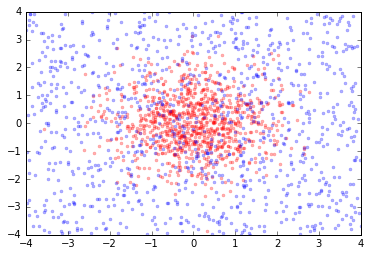

In [135]:
np.random.seed(1234)
xp1 = np.random.randn(1000,1)
xp2 = np.random.randn(1000,1)
pcls = np.zeros((1000))
pcls[:] = 1
xn1 = np.random.random((1000,1))*8-4
xn2 = np.random.random((1000,1))*8-4
ncls = np.zeros((1000))
ncls[:] = -1
x1s = np.concatenate([xp1, xn1])
x2s = np.concatenate([xp2, xn2])
cls = np.concatenate([pcls, ncls])
features = np.concatenate((x1s, x2s), axis=1)

cls>0
plt.plot(features[cls>0, 0], features[cls>0, 1], '.r', alpha=0.3)
plt.plot(features[cls<0, 0], features[cls<0, 1], '.b', alpha=0.3)

In [151]:
def make_tree(features, cls):
    pass

def gini(cls):
    npos = sum(cls > 0)
    nneg = sum(cls < 0)
    if npos+nneg == 0:
        return 10.0
    p = float(npos)/(npos+nneg)
    return p*(1-p)

def theta(s):
    return 1./(1+math.exp(-s))

def nscore(ndata):
    return theta((ndata-25)/25)*.25

CutScore = namedtuple('CutScore', ['vid', 'cut', 'score', 'leftidx', 'rightidx'])

def find_bestcut(features, cls):
    nfeatures = features.shape[1]
    ntries = 10
    cut_scores = []
    for vid in range(nfeatures):
        minv, maxv = min(features[:, vid]), max(features[:, vid])
        cuts = np.linspace(minv, maxv, ntries+2)[1:-1]
        for cut in cuts:
            leftidx = features[:, vid] < cut
            nleft = sum(leftidx)
            rightidx = features[:, vid] >= cut
            nright = sum(rightidx)
            left_gini = gini(cls[leftidx])
            right_gini = gini(cls[rightidx])
            score = left_gini + right_gini + nscore(nleft) + nscore(nright)
            cut_scores.append(CutScore(vid, cut, score, leftidx, rightidx))
    
    #all scores for each cut is calculated select the one with lowest gini index
    bestcut = min(cut_scores, key=lambda x: x.score)
    return bestcut

find_bestcut(xs, cls)

def make_tree(features, cls, minleaf=10):
    npos = sum(cls>0)
    nneg = sum(cls<0)
    nfeatures = features.shape[1]
    
    #base case
    if npos==0 or nneg==0 or npos+nneg < minleaf:
        return make_leaf_node(npos, nneg) 
    
    bestcut = find_bestcut(features, cls)
    decision_node = make_decision_node(bestcut.vid, bestcut.cut, npos, nneg)
    decision_node.left = make_tree(features[bestcut.leftidx], cls[bestcut.leftidx], minleaf)
    decision_node.right = make_tree(features[bestcut.rightidx], cls[bestcut.rightidx], minleaf)
    return decision_node

dtree = make_tree(xs, cls, 20)

In [152]:
#visualize_tree(dtree, depth_limit=50)

In [153]:
dtree.classify([1,1])

0.875

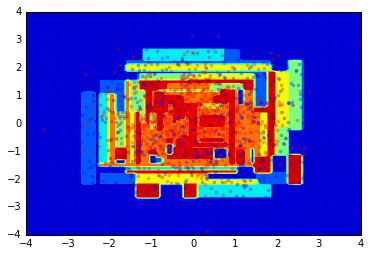

In [154]:
allxs = np.linspace(-4,4, 100)
allys = np.linspace(-4,4, 100)
allz = np.zeros((100, 100))
for ix, x in enumerate(allxs):
    for iy, y in enumerate(allys):
        allz[ix,iy] = dtree.classify([x,y])
plt.contourf(allxs, allys, allz)
plt.plot(features[cls>0, 0], features[cls>0, 1], '.r', alpha=0.3)
plt.plot(features[cls<0, 0], features[cls<0, 1], '.b', alpha=0.3)        
